<div style="font-size:1.4em; margin-bottom:2em">
    <div style="float:right; line-height:1.2em;">GET Lab<br />Paderborn University</div>
  <div>SS 2021</div>
</div>
<div style="clear:both"></div>
<div style="text-align:center; font-size:1.8em;">
  Digital Image Processing II<br />Task Sheet 6
</div>

<hr>

### Overview

The objective of this task sheet is to reimplement the scale space construction of the Scale-Invariant Feature Transform (SIFT) by <a href="https://cecas.clemson.edu/~stb/ece847/internal/classic_vision_papers/lowe_sift_ijcv2004.pdf">Lowe (2004)</a>. The results are compared with the OpenCV implementation of SIFT.

SIFT extracts local image features in the form of keypoints, which are surrounded by specific regions. The features are invariant to scale and rotation changes and are robust against illumination and viewpoint changes. They are detected and analyzed in a scale space, which is a one-parameter family of smoothed versions of the input image. The idea is that structures in digital images appear different depending on the (typically unknown) scale of observation. In a scale space, this behavior can be simulated and analyzed in a systematic manner.

After a preprocessing step, the algorithm can be summarized as follows (see lecture notes for details):
1. **Scale space construction**: Compute the Gaussian-filtered images $L(x,y,\sigma)$, as shown below.
2. **Obtaining initial (candidate) keypoints**: Compute the Difference of Gaussian (DoG) images $D(x,y,\sigma)$, as shown below, and search for extrema in the DoG images. These extrema are keypoint candidates.
3. **Improving the accuracy of keypoint locations**: The accuracy of $(x,y,\sigma)$ of each keypoint can be improved based on a quadratic Taylor expansion of $D(x,y,\sigma)$.
4. **Deleting unstable keypoints**: Keypoints that have a low contrast (they are not distinctive) and/or are located along edges (they are poorly localized) are deleted.
5. **Computing keypoint orientations**: Each keypoint is assigned one or more characteristic (reference) orientations using a histogram-based procedure.
6. **Computing keypoint descriptors**: Each keypoint is assigned a 128-dimensional feature vector, which is computed relative to the characteristic scale and orientation.

The DoG images are an approximation of Laplacian of Gaussian (LoG) images, as for example used by the Marr-Hildreth Edge Detector. But instead of searching for zero-crossings, SIFT searches for extrema. As the filter response is highest if the filter form is similar to the image structure, SIFT searches for circular regions with LoG form.

The following figure shows the implementation of the scale space for three octaves:

<center><img src="images/sift-scale-space.png" width="400px" /></center>

In this example, the following parameters are used:
* $\sigma_1 = 1.6$: Initial scale of the first octave.
* $s=2$: Number of DoG layers per octave used to search for extrema (also called intervals per octave).<br/> This leads to $s+3=2+3=5$ Gaussian images and $s+2=4$ DoG images per octave.
* $k = 2^{1/s} = \sqrt{2}$: Factor between the scales within an octave.
* Octaves: 3

Note: Depending on the reference (implementation), the scale space is not always created in the exact same way. For example, the Gaussians are sometimes repeatedly convolved with the same standard deviation, which leads to similar but not the same results. 

---

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

dpi = plt.rcParams['figure.dpi']

# plot image in original size
def plot_img_orig(img):
    fig = plt.figure(figsize = (img.shape[1]/dpi, img.shape[0]/dpi))
    fig.add_axes([0, 0, 1, 1])
    plt.axis('off')
    plt.imshow(img, cmap='gray', vmin=0, vmax=255) # cmap parameter is ignored for RGB(A) data
    plt.show()

#### <span style="color: RoyalBlue; font-weight: bold;">Task 6.1</span> Scale Space Construction and Extrema Detection

**Preprocessing:** Before the construction of the scale space, the original image is smoothed with a Gaussian with $\sigma = 0.5$ and then doubled in size by linear (nearest-neighbor) interpolation. The resulting initial image is then smoothed with $\sigma_1$ to create the *first* image of the *first* octave of the scale space. It can be shown that this preprocessing improves the number of stable keypoints.

Implement / solve the following tasks:
1. Write a function which returns the Gaussian filtered image for a given $\sigma$ based on a $n\times n$ mask with $n=2\lceil 3\sigma\rceil+1$.
2. Read a test image (e.g., *p-building-small.png*) and create the smoothed and double sized initial image for the first octave.

The function from subtask 1 can also be used in the next steps.

Input image:


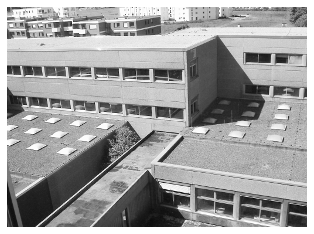

Smoothed image:


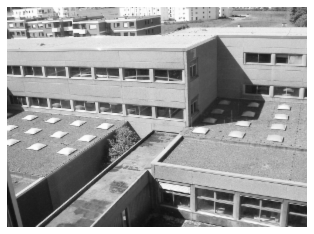

Interpolated image:


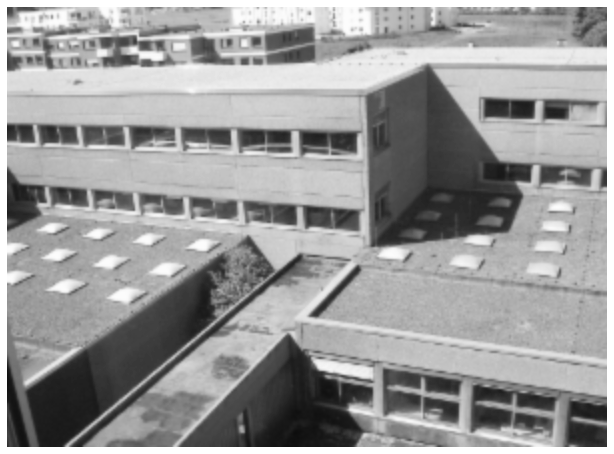

In [2]:
# write your code here

# compute Gaussian filtered image for given standard deviation (scale) sigma
def gaussianBlur(img, sigma):
    n = int(2*np.ceil(3*sigma)+1) # size of the mask
    res = cv2.GaussianBlur(img, (n, n), sigma) # filter the image (function uses reflection padding - BORDER_REFLECT_101)

    return res # return result

# instead of this function, the following command can be used
#cv2.GaussianBlur(img, (0, 0), sigma) # n is computed automatically then

# read the image as a grayscale image (parameter 0) and plot it
img = cv2.imread('images/p-building-small.png', 0)
print("Input image:")
plot_img_orig(img)

# smooth original image
img_smoothed = gaussianBlur(img, 0.5)
print("Smoothed image:")
plot_img_orig(img_smoothed)

# compute initial image
img_init_oct1 = cv2.resize(img_smoothed, None, (0, 0), 2.0, 2.0, cv2.INTER_LINEAR)
print("Interpolated image:")
plot_img_orig(img_init_oct1)

**Step 1: Scale space construction.** In this step, the scale space (the stack of Gaussian smoothed images) is constructed as shown in the overview. Each scale space image can be computed either by always smoothing the initial image with an appropriate Gaussian or by smoothing the already smoothed image again. In the latter case, it has to be considered that using two Gaussians with $\sigma_1$ and $\sigma_2$ successively leads to a smoothing equivalent to $\sigma = \sqrt{\sigma_1^2 + \sigma_2^2}$. In other words, $\sigma_2$ has to be computed based on this formula to get the desired $\sigma$, when an image has already been smoothed with $\sigma_1$. With this approach, the smoothing can be implemented faster because the Gaussian masks are smaller then. In this example, we use the first variant so that we have the desired $\sigma$ directly (even though it is slower).

The *first* image of the *second* octave is formed by downsampling the original image (after the preprocessing step) by skipping every other row and column, and then smoothing it with $\sigma_2 = 2\sigma_1$. It is also possible to take the third image from the first octave and downsample it directly, as $k^2 = 2$. This is also why the third image from the top of each octave is called *octave image*. In this example, we downsample the original image. The process is repated for further octaves.

Implement / solve the following tasks:
1. Compute the Gaussian filtered image of each octave and plot the results.

Note: For a better overview, each octave image can be stored as *one* channel of *one* image, for example `oct1_gauss = np.zeros((rows1, cols1, s+3), dtype=np.float64)` for octave 1. 

Octave 1:


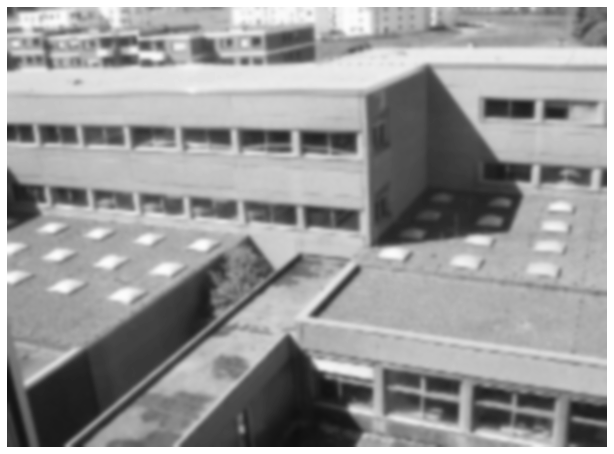

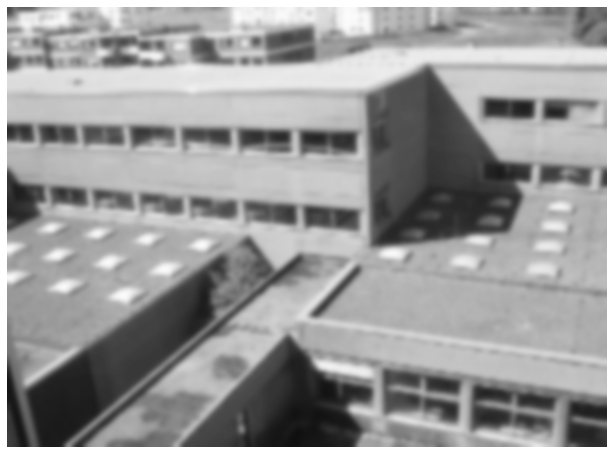

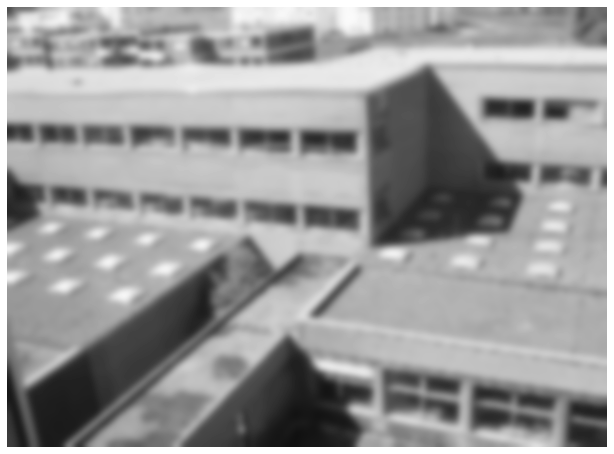

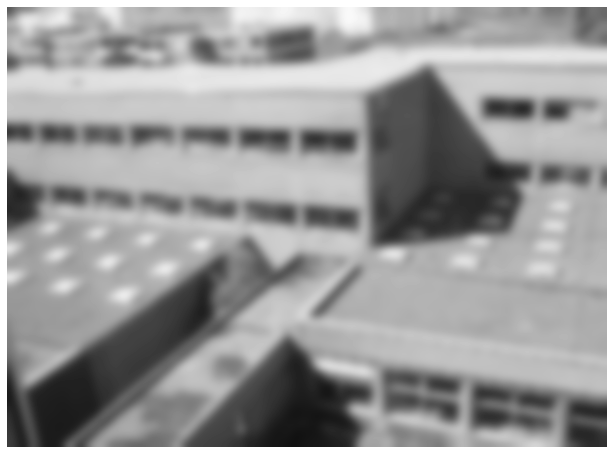

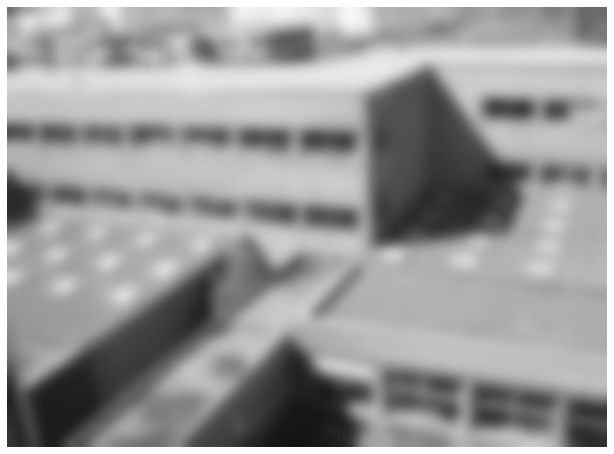

Octave 2:


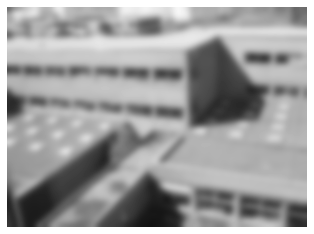

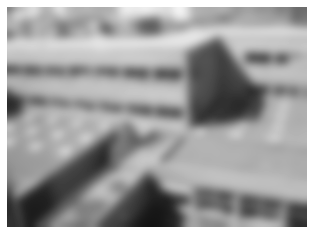

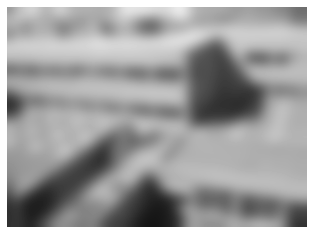

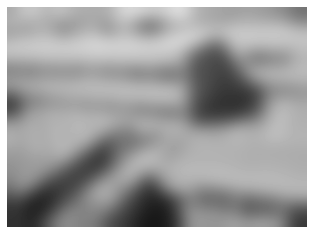

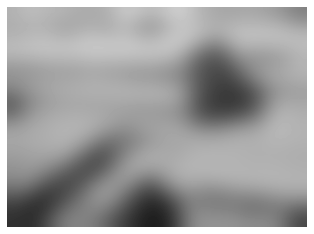

Octave 3:


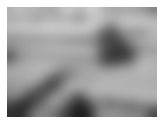

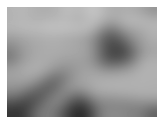

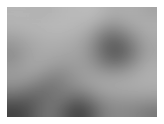

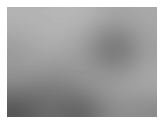

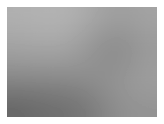

In [3]:
# write your code here

# parameters
sigma1 = 1.6 # sigma_1 (sigma of first image in first octave)
s = 2 # intervals per octave
k = 2 ** (1/s) # factor between the scales

# octave 1
rows1, cols1 = img_init_oct1.shape # size of the initial image
oct1_gauss = np.zeros((rows1, cols1, s+3), dtype=np.float64) # each channel is one scale space image

# compute images of first octave
print("Octave 1:")
for i in range(s+3):
    sigma = (k ** i) * sigma1
    oct1_gauss[:,:,i] = gaussianBlur(img_init_oct1, sigma)
    plot_img_orig(oct1_gauss[:,:,i])
    
# octave 2
img_init_oct2 = cv2.resize(img_init_oct1, None, (0, 0), 0.5, 0.5, cv2.INTER_NEAREST)
rows2, cols2 = img_init_oct2.shape
oct2_gauss = np.zeros((rows2, cols2, s+3), dtype=np.float64) # each channel is one scale space image
sigma2 = 2 * sigma1

# compute images of second octave
print("Octave 2:")
for i in range(s+3):
    sigma = (k ** i) * sigma2
    oct2_gauss[:,:,i] = gaussianBlur(img_init_oct2, sigma)
    plot_img_orig(oct2_gauss[:,:,i])
    
# octave 3
img_init_oct3 = cv2.resize(img_init_oct2, None, (0, 0), 0.5, 0.5, cv2.INTER_NEAREST)
rows3, cols3 = img_init_oct3.shape
oct3_gauss = np.zeros((rows3, cols3, s+3), dtype=np.float64) # each channel is one scale space image
sigma3 = 2 * sigma2

# compute images of third octave
print("Octave 3:")
for i in range(s+3):
    sigma = (k ** i) * sigma3
    oct3_gauss[:,:,i] = gaussianBlur(img_init_oct3, sigma)
    plot_img_orig(oct3_gauss[:,:,i])

 Note that the scale increases from to bottom here (upside down version of the pyramid from the overview).

**Step 2: Obtaining the initial keypoints.** In this step, the DoG images are computed as shown in the overview. The next step is to find the extrema in the DoG images by comparing each pixel to its 26 neighbors. A pixel is selected as an extremum (keypoint candidate), if its value is larger or smaller than the values of all 26 neighbors. The following figure illustrates the method:

<center><img src="images/sift-neighbors.png" width="200px" /></center>

Note that these checks can only be performed for the $s$ inner DoG images with a layer above and below.

Implement / solve the following tasks:
1. Compute and plot the (normalized) DoG images of each octave.
2. Compute and plot (mark) the extrema (= candidate keypoints) in the $s = 2$ inner DoG images.

DoG images (normalized):
Octave 1:


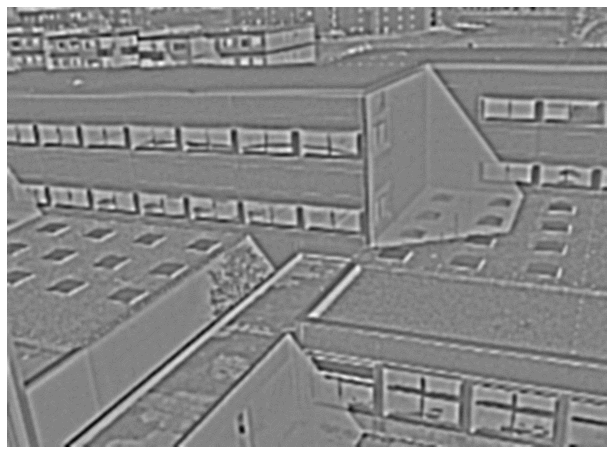

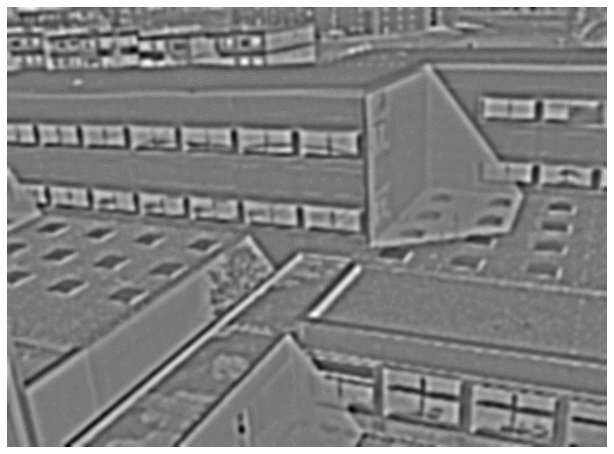

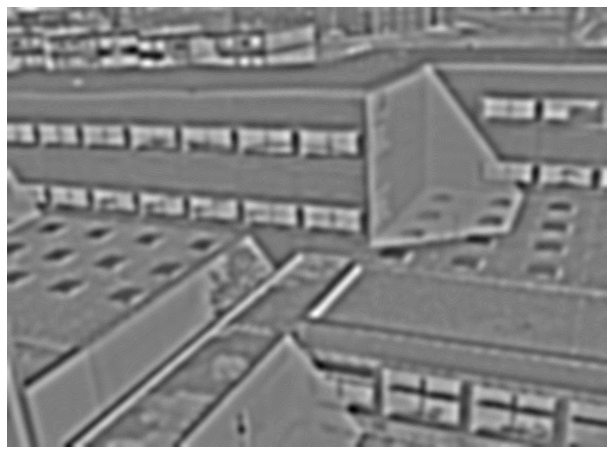

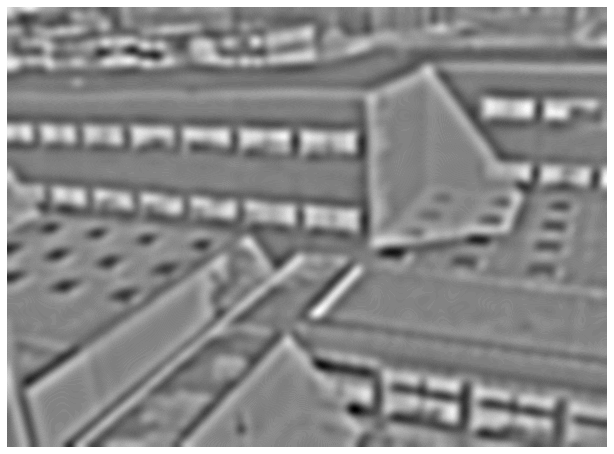

Octave 2:


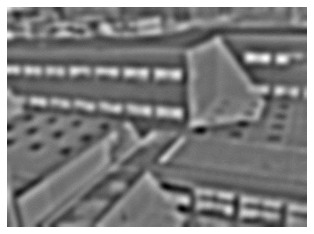

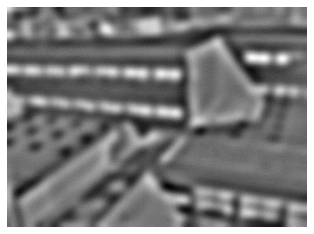

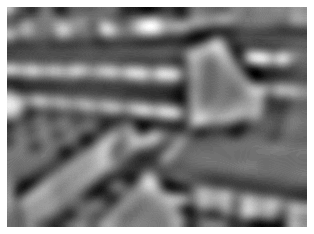

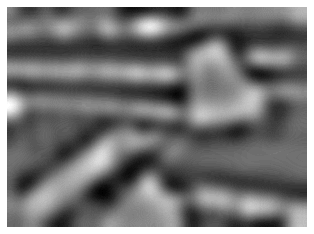

Octave 3:


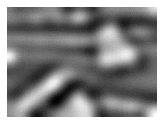

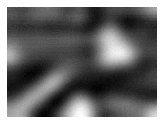

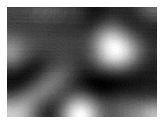

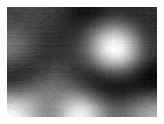

Detected extrema:
Octave 1:


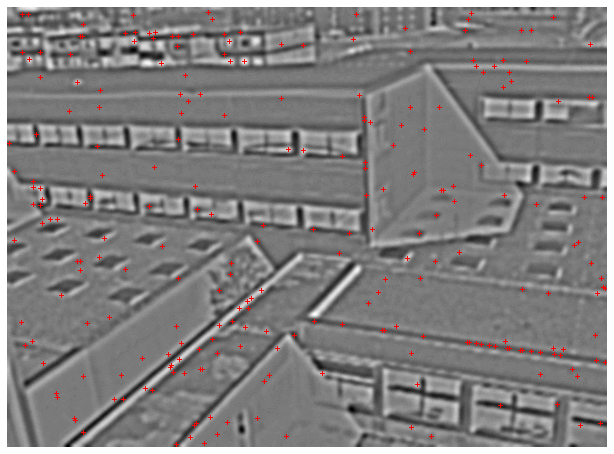

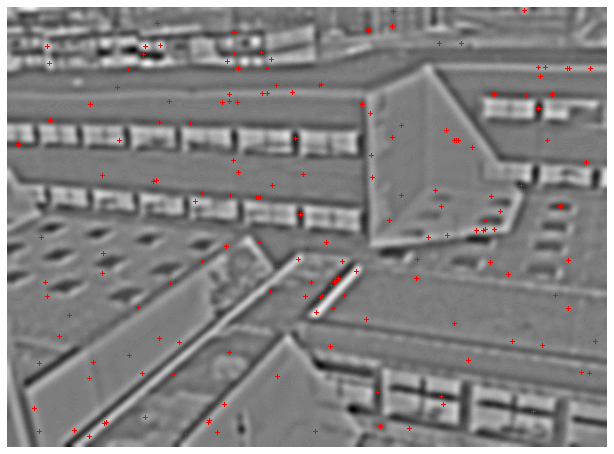

Octave 2:


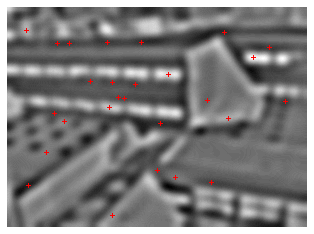

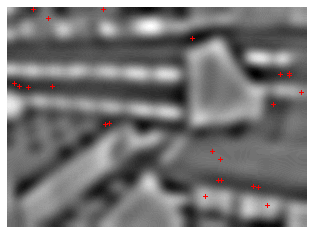

Octave 3:


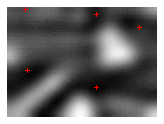

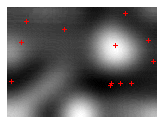

In [4]:
# write your code here

# compute DoG images
oct1_dog = np.zeros((rows1, cols1, s+2), dtype=np.float64) # each channel is one DoG image
oct2_dog = np.zeros((rows2, cols2, s+2), dtype=np.float64) # each channel is one DoG image
oct3_dog = np.zeros((rows3, cols3, s+2), dtype=np.float64) # each channel is one DoG image

# scale increases with i
for i in range(s+2):
    oct1_dog[:,:,i] = oct1_gauss[:,:,i+1]-oct1_gauss[:,:,i]
    oct2_dog[:,:,i] = oct2_gauss[:,:,i+1]-oct2_gauss[:,:,i]
    oct3_dog[:,:,i] = oct3_gauss[:,:,i+1]-oct3_gauss[:,:,i]

print("DoG images (normalized):")
# plot of the DoG images
print("Octave 1:")
for i in range(s+2):
    tmp = cv2.normalize(oct1_dog[:,:,i], None, 0, 255, cv2.NORM_MINMAX)
    plot_img_orig(tmp)

print("Octave 2:")
for i in range(s+2):
    tmp = cv2.normalize(oct2_dog[:,:,i], None, 0, 255, cv2.NORM_MINMAX)
    plot_img_orig(tmp)

print("Octave 3:")
for i in range(s+2):
    tmp = cv2.normalize(oct3_dog[:,:,i], None, 0, 255, cv2.NORM_MINMAX)
    plot_img_orig(tmp)
    
# check if value is larger or smaller than all 26 neighbors
# octave 1
oct1_ext = [] # empty array to save extrema
for d in range(1, s+1): # DoG layers to search for extrema
    for i in range(1, rows1-1): # leave out the image border
        for j in range(1, cols1-1):
            # save the 26 neighbors in a 1D array
            top = oct1_dog[i-1:i+2, j-1:j+2, d-1].flatten() # top layer
            cnt = oct1_dog[i-1:i+2, j-1:j+2, d].flatten() # center layer 
            low = oct1_dog[i-1:i+2, j-1:j+2, d+1].flatten() # lower layer

            cnt = np.delete(cnt, 4) # delete center element
            nbh = np.concatenate((top, cnt, low)) # concatenate all values to 1d array
            
            if (oct1_dog[i, j, d] < np.amin(nbh)) or (oct1_dog[i, j, d] > np.amax(nbh)):
                # scale space extremum found
                oct1_ext.append([i, j, d])
                
# octave 2
oct2_ext = [] # empty array to save extrema
for d in range(1, s+1): # DoG layers to search for extrema
    for i in range(1, rows2-1): # leave out the image border
        for j in range(1, cols2-1):
            # save the 26 neighbors in a 1D array
            top = oct2_dog[i-1:i+2, j-1:j+2, d-1].flatten() # top layer
            cnt = oct2_dog[i-1:i+2, j-1:j+2, d].flatten() # center layer 
            low = oct2_dog[i-1:i+2, j-1:j+2, d+1].flatten() # lower layer

            cnt = np.delete(cnt, 4) # delete center element
            nbh = np.concatenate((top, cnt, low)) # concatenate all values to 1d array
            
            if (oct2_dog[i, j, d] < np.amin(nbh)) or (oct2_dog[i, j, d] > np.amax(nbh)):
                # scale space extremum found
                oct2_ext.append([i, j, d])
                
# octave 3
oct3_ext = [] # empty array to save extrema
for d in range(1, s+1): # DoG layers to search for extrema
    for i in range(1, rows3-1): # leave out the image border
        for j in range(1, cols3-1):
            # save the 26 neighbors in a 1D array
            top = oct3_dog[i-1:i+2, j-1:j+2, d-1].flatten() # top layer
            cnt = oct3_dog[i-1:i+2, j-1:j+2, d].flatten() # center layer 
            low = oct3_dog[i-1:i+2, j-1:j+2, d+1].flatten() # lower layer

            cnt = np.delete(cnt, 4) # delete center element
            nbh = np.concatenate((top, cnt, low)) # concatenate all values to 1d array
            
            if (oct3_dog[i, j, d] < np.amin(nbh)) or (oct3_dog[i, j, d] > np.amax(nbh)):
                # scale space extremum found
                oct3_ext.append([i, j, d])
                
# plot extrema in DoG images
oct1_ext_plot = np.zeros((rows1, cols1, s), dtype=np.float64) # each channel is one DoG image
oct2_ext_plot = np.zeros((rows2, cols2, s), dtype=np.float64) # each channel is one DoG image
oct3_ext_plot = np.zeros((rows3, cols3, s), dtype=np.float64) # each channel is one DoG image

print("Detected extrema:")
# octave 1
print("Octave 1:")
for d in range(1, s+1):
    tmp = cv2.normalize(oct1_dog[:,:,d], None, 0, 255, cv2.NORM_MINMAX) # normalization of current DoG image to [0, 255]
    tmp = tmp.astype(np.uint8) # change datatype
    tmp = cv2.cvtColor(tmp, cv2.COLOR_GRAY2RGB) # convert to RGB
    
    for i in range(len(oct1_ext)):
        row = oct1_ext[i][0]
        col = oct1_ext[i][1]
        dog = oct1_ext[i][2] # index of layer of extremum in oct1_dog 
    
        if d == dog: # extrema in current DoG image
            cv2.drawMarker(tmp, (col, row), color=(255, 0, 0), markerType=cv2.MARKER_CROSS, thickness=1, markerSize=5)
    
    plot_img_orig(tmp)
    
# octave 2
print("Octave 2:")
for d in range(1, s+1):
    tmp = cv2.normalize(oct2_dog[:,:,d], None, 0, 255, cv2.NORM_MINMAX) # normalization of current DoG image to [0, 255]
    tmp = tmp.astype(np.uint8) # change datatype
    tmp = cv2.cvtColor(tmp, cv2.COLOR_GRAY2RGB) # convert to RGB
    
    for i in range(len(oct2_ext)):
        row = oct2_ext[i][0]
        col = oct2_ext[i][1]
        dog = oct2_ext[i][2] # index of layer of extremum in oct1_dog 
    
        if d == dog: # extrema in current DoG image
            cv2.drawMarker(tmp, (col, row), color=(255, 0, 0), markerType=cv2.MARKER_CROSS, thickness=1, markerSize=5)
    
    plot_img_orig(tmp)
    
# octave 3
print("Octave 3:")
for d in range(1, s+1):
    tmp = cv2.normalize(oct3_dog[:,:,d], None, 0, 255, cv2.NORM_MINMAX) # normalization of current DoG image to [0, 255]
    tmp = tmp.astype(np.uint8) # change datatype
    tmp = cv2.cvtColor(tmp, cv2.COLOR_GRAY2RGB) # convert to RGB
    
    for i in range(len(oct3_ext)):
        row = oct3_ext[i][0]
        col = oct3_ext[i][1]
        dog = oct3_ext[i][2] # index of layer of extremum in oct1_dog 
    
        if d == dog: # extrema in current DoG image
            cv2.drawMarker(tmp, (col, row), color=(255, 0, 0), markerType=cv2.MARKER_CROSS, thickness=1, markerSize=5)
    
    plot_img_orig(tmp)

#### <span style="color: RoyalBlue; font-weight: bold;">Task 6.2</span> Keypoints in OpenCV

OpenCV provides data structures and functions for handling keypoints and descriptors of many different algorithms. The detected keypoints from the previous task should now be saved as <a href="https://docs.opencv.org/4.2.0/d2/d29/classcv_1_1KeyPoint.html">OpenCV keypoints</a>. After that, the OpenCV function <a href="https://docs.opencv.org/4.2.0/d4/d5d/group__features2d__draw.html#ga5d2bafe8c1c45289bc3403a40fb88920">`drawKeypoints`</a> can be used to plot the keypoints together with circular regions representing the characteristic scales.

Implement / solve the following tasks:
1. Save the detected keypoints in a list of <a href="https://docs.opencv.org/4.2.0/d2/d29/classcv_1_1KeyPoint.html">OpenCV keypoints</a>, where each keypoint has the format `cv2.KeyPoint(col, row, size)`. The `size` parameter can be computed as $3\cdot \mathrm{scale}$, where $\mathrm{scale}$ is the characteristic scale of the keypoint.
2. Use the OpenCV function <a href="https://docs.opencv.org/4.2.0/d4/d5d/group__features2d__draw.html#ga5d2bafe8c1c45289bc3403a40fb88920">`drawKeypoints`</a> to plot the keypoints.

Keypoints in octave 1: 417
Keypoints in octave 2: 50
Keypoints in octave 3: 17


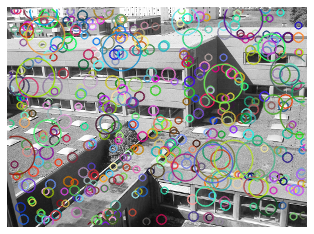

In [5]:
# write your code here

# extrema / keypoints are stored in octN_ext
print("Keypoints in octave 1: " + str(len(oct1_ext)))
print("Keypoints in octave 2: " + str(len(oct2_ext)))
print("Keypoints in octave 3: " + str(len(oct3_ext)))

# factor for region size which indicates the scale
factor = 3

# empty list to store all keypoints
kp = []

# append all keypoints to kp
# octave 1
for i in range(len(oct1_ext)):
    row = int(oct1_ext[i][0] / 2) # original image size has been doubled in preprocessing
    col = int(oct1_ext[i][1] / 2) # therefore division by 2
    dog = oct1_ext[i][2] # index of layer of extremum in oct1_dog
    
    # x is the horizontal axis in OpenCV
    size = (k ** dog) * sigma1 * factor
    p = cv2.KeyPoint(col, row, size) # format: cv.KeyPoint(x, y, size[, angle[, response[, octave[, class_id]]]]) 
    kp.append(p)
    
# octave 2
for i in range(len(oct2_ext)):
    row = oct2_ext[i][0]
    col = oct2_ext[i][1] 
    dog = oct2_ext[i][2] # index of layer of extremum in oct2_dog
    
    # x is the horizontal axis in OpenCV
    size = (k ** dog) * sigma2 * factor
    p = cv2.KeyPoint(col, row, size) # format: cv.KeyPoint(x, y, size[, angle[, response[, octave[, class_id]]]]) 
    kp.append(p)
    
# octave 3
for i in range(len(oct3_ext)):
    row = oct3_ext[i][0] * 2
    col = oct3_ext[i][1] * 2
    dog = oct3_ext[i][2] # index of layer of extremum in oct3_dog
    
    # x is the horizontal axis in OpenCV
    size = (k ** dog) * sigma3 * factor
    p = cv2.KeyPoint(col, row, size) # format: cv.KeyPoint(x, y, size[, angle[, response[, octave[, class_id]]]]) 
    kp.append(p)
    
# draw keypoints with scales
img_kp_own = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plot_img_orig(img_kp_own)

#### <span style="color: RoyalBlue; font-weight: bold;">Task 6.3</span> OpenCV Implementation of SIFT

OpenCV provides an implementation of SIFT which can be used here to compare the results from the previous tasks. <a href="https://docs.opencv.org/4.2.0/da/df5/tutorial_py_sift_intro.html">This OpenCV tutorial</a> shows how to use the OpenCV implementation.

Implement / solve the following tasks:
1. Use the OpenCV implementation of SIFT to detect keypoints and to compute their descriptors.
2. Use the OpenCV function <a href="https://docs.opencv.org/4.2.0/d4/d5d/group__features2d__draw.html#ga5d2bafe8c1c45289bc3403a40fb88920">`drawKeypoints`</a> to plot the keypoints.
3. Compare the results with your own keypoints.

Input image:


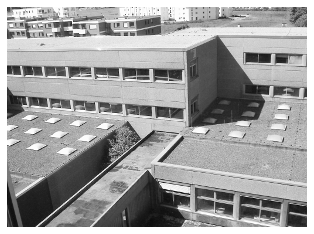

SIFT Keypoints:


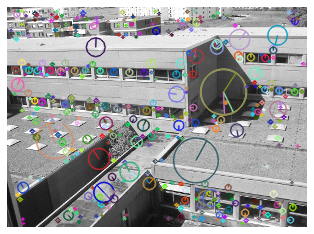

Own Keypoints:


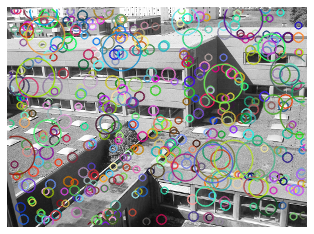

In [6]:
# write your code here

# read the image as a grayscale image (parameter 0) and plot it
img1 = cv2.imread('images/p-building-small.png', 0)
print("Input image:")
plot_img_orig(img1)

# create SIFT object
sift = cv2.xfeatures2d.SIFT_create(0, 2) # format: cv.SIFT_create([, nfeatures[, nOctaveLayers[, ... ]]])

# detect SIFT keypoints and compute descriptors
kp1, desc1 = sift.detectAndCompute(img1, None)

# draw keypoints with scales and orientations
img_kp1 = cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# plot result
print("SIFT Keypoints:")
plot_img_orig(img_kp1)

print("Own Keypoints:")
plot_img_orig(img_kp_own)

The number of own keypoints is much higher because they have not been filtered (step 4). While some keypoints seem to be similar, there are also significant differences, even though the most important parameters should be the same. At the moment, the reasons for this behaviour are unclear. One reason might be the missing accuracy improvement of keypoint locations in step 3.

#### <span style="color: RoyalBlue; font-weight: bold;">Task 6.4</span> Keypoint Matching

To find correspondences between different keypoints, one of the simplest methods is Brute-Force Matching. Assuming that we have two images with a set of detected keypoints and descriptors, each descriptor from the first set is compared with each descriptor from the second set, and the closest match (for example, shortest euclidean distance) is returned. <a href="https://www.docs.opencv.org/4.2.0/dc/dc3/tutorial_py_matcher.html">This OpenCV tutorial</a> shows how to use the corresponding OpenCV implementation.

Implement / solve the following tasks:
1. Use the Brute-Force Matcher of OpenCV to match the keypoints of two different test images (e.g., *p-building-small.png* and *p-building-tiny.png*).
2. Draw the results by using the OpenCV function <a href="https://docs.opencv.org/4.2.0/d4/d5d/group__features2d__draw.html#gad8f463ccaf0dc6f61083abd8717c261a">`drawMatches`</a>.

SIFT Keypoints:


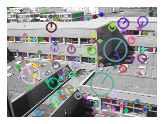

Matches:


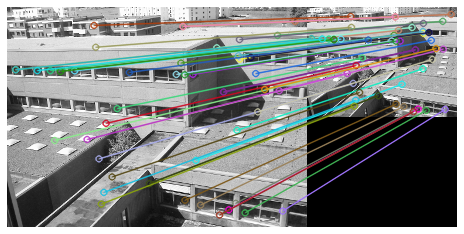

In [7]:
# write your code here

# see previous task for img1

# read second image as a grayscale image (parameter 0) and plot it
img2 = cv2.imread('images/p-building-tiny.png', 0)

# detect SIFT keypoints and compute descriptors
kp2, desc2 = sift.detectAndCompute(img2, None)

# draw keypoints with scales and orientations
img_kp2 = cv2.drawKeypoints(img2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# plot the keypoints
print("SIFT Keypoints:")
plot_img_orig(img_kp2)

# create BFMatcher object
bf = cv2.BFMatcher()

# match descriptors
matches = bf.match(desc1, desc2)

# sort matches in the order of their distance
matches = sorted(matches, key = lambda x:x.distance)

# draw matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# plot the result
print("Matches:")
plot_img_orig(img_matches)